In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import joblib



In [2]:
df = pd.read_csv ('./selected_columns.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430755 entries, 0 to 430754
Data columns (total 30 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _MICHD    430755 non-null  int64  
 1   CHOLMED3  430755 non-null  int64  
 2   GENHLTH   430755 non-null  int64  
 3   MAXVO21_  430755 non-null  float64
 4   EMPLOY1   430755 non-null  int64  
 5   BPHIGH6   430755 non-null  int64  
 6   DIABETE4  430755 non-null  int64  
 7   CVDSTRK3  430755 non-null  int64  
 8   _AGE80    430755 non-null  int64  
 9   VETERAN3  430755 non-null  int64  
 10  CHCCOPD3  430755 non-null  int64  
 11  CHILDREN  430755 non-null  int64  
 12  _DRDXAR2  430755 non-null  int64  
 13  DEAF      430755 non-null  int64  
 14  DIFFWALK  430755 non-null  int64  
 15  TOLDHI3   430755 non-null  int64  
 16  PHYSHLTH  430755 non-null  int64  
 17  CHCKDNY2  430755 non-null  int64  
 18  FALL12MN  430755 non-null  int64  
 19  _RFCHOL3  430755 non-null  int64  
 20  TRNS

In [3]:
#Kiểm tra các giá trị của CVDINFR4
df['CVDINFR4'].value_counts()

CVDINFR4
0    407304
1     23451
Name: count, dtype: int64

In [4]:


def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No CVD', 'CVD'], yticklabels=['No CVD', 'CVD'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
# Hàm đánh giá
def evaluate_model(y_true, y_pred, model_name):
    print(f"Đánh giá cho {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    plot_confusion_matrix(y_true, y_pred, model_name)


In [5]:

class NeuralNetwork:
    def __init__(self, input_size, class_weight=None):
        # Khởi tạo các tham số
        self.W1 = np.random.randn(input_size, 128) * np.sqrt(2./input_size)
        self.b1 = np.zeros(128)
        self.W2 = np.random.randn(128, 64) * np.sqrt(2./128)
        self.b2 = np.zeros(64)
        self.W3 = np.random.randn(64, 32) * np.sqrt(2./64)
        self.b3 = np.zeros(32)
        self.W4 = np.random.randn(32, 1) * np.sqrt(2./32)
        self.b4 = np.array([np.log(2319/40757)])  # Khởi tạo bias
        
        # Adam parameters
        self.m_W = [np.zeros_like(w) for w in [self.W1, self.W2, self.W3, self.W4]]
        self.v_W = [np.zeros_like(w) for w in [self.W1, self.W2, self.W3, self.W4]]
        self.m_b = [np.zeros_like(b) for b in [self.b1, self.b2, self.b3, self.b4]]
        self.v_b = [np.zeros_like(b) for b in [self.b1, self.b2, self.b3, self.b4]]
        
        self.class_weight = class_weight or {0:1, 1:1}
        self.eps = 1e-8
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.t = 0

    def relu(self, x):
        return np.maximum(0, x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def forward(self, X):
        # Layer 1
        self.z1 = X.dot(self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        
        # Layer 2
        self.z2 = self.a1.dot(self.W2) + self.b2
        self.a2 = self.relu(self.z2)
        
        # Layer 3
        self.z3 = self.a2.dot(self.W3) + self.b3
        self.a3 = self.relu(self.z3)
        
        # Output layer
        self.z4 = self.a3.dot(self.W4) + self.b4
        return self.sigmoid(self.z4)

    def compute_loss(self, y, y_pred):
        y = y.reshape(-1, 1)
        weights = np.vectorize(lambda x: self.class_weight[x])(y)
        y_pred = np.clip(y_pred, 1e-7, 1-1e-7)
        return -np.mean(weights * (y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)))

    def update(self, param, m, v, grad, lr):
        self.t += 1
        m = self.beta1 * m + (1 - self.beta1) * grad
        v = self.beta2 * v + (1 - self.beta2) * (grad**2)
        m_hat = m / (1 - self.beta1**self.t)
        v_hat = v / (1 - self.beta2**self.t)
        return param - lr * m_hat / (np.sqrt(v_hat) + self.eps), m, v

    def fit(self, X, y, X_val, y_val, epochs=100, lr=0.001, batch_size=128):
        best_f1 = 0
        best_thresh = 0.5
        
        for epoch in range(epochs):
            # Mini-batch training
            indices = np.random.permutation(X.shape[0])
            for i in range(0, X.shape[0], batch_size):
                batch_idx = indices[i:i+batch_size]
                X_batch = X[batch_idx]
                y_batch = y.iloc[batch_idx].values
                
                # Forward pass
                y_pred = self.forward(X_batch)
                
                # Backpropagation
                grad_z4 = (y_pred - y_batch.reshape(-1,1)) * np.vectorize(lambda x: self.class_weight[x])(y_batch).reshape(-1,1) / batch_size
                
                # Gradients
                grad_W4 = self.a3.T.dot(grad_z4)
                grad_b4 = np.sum(grad_z4, axis=0)
                
                grad_a3 = grad_z4.dot(self.W4.T)
                grad_z3 = grad_a3 * (self.z3 > 0)
                grad_W3 = self.a2.T.dot(grad_z3)
                grad_b3 = np.sum(grad_z3, axis=0)
                
                grad_a2 = grad_z3.dot(self.W3.T)
                grad_z2 = grad_a2 * (self.z2 > 0)
                grad_W2 = self.a1.T.dot(grad_z2)
                grad_b2 = np.sum(grad_z2, axis=0)
                
                grad_a1 = grad_z2.dot(self.W2.T)
                grad_z1 = grad_a1 * (self.z1 > 0)
                grad_W1 = X_batch.T.dot(grad_z1)
                grad_b1 = np.sum(grad_z1, axis=0)
                
                # Update parameters with Adam
                self.W4, self.m_W[3], self.v_W[3] = self.update(self.W4, self.m_W[3], self.v_W[3], grad_W4, lr)
                self.b4, self.m_b[3], self.v_b[3] = self.update(self.b4, self.m_b[3], self.v_b[3], grad_b4, lr)
                self.W3, self.m_W[2], self.v_W[2] = self.update(self.W3, self.m_W[2], self.v_W[2], grad_W3, lr)
                self.b3, self.m_b[2], self.v_b[2] = self.update(self.b3, self.m_b[2], self.v_b[2], grad_b3, lr)
                self.W2, self.m_W[1], self.v_W[1] = self.update(self.W2, self.m_W[1], self.v_W[1], grad_W2, lr)
                self.b2, self.m_b[1], self.v_b[1] = self.update(self.b2, self.m_b[1], self.v_b[1], grad_b2, lr)
                self.W1, self.m_W[0], self.v_W[0] = self.update(self.W1, self.m_W[0], self.v_W[0], grad_W1, lr)
                self.b1, self.m_b[0], self.v_b[0] = self.update(self.b1, self.m_b[0], self.v_b[0], grad_b1, lr)
            
            # Tìm ngưỡng tối ưu trên validation set
            y_val_pred = self.forward(X_val).flatten()
            thresholds = np.linspace(0.1, 0.5, 50)
            current_best_f1 = 0
            for thresh in thresholds:
                current_f1 = f1_score(y_val, (y_val_pred >= thresh).astype(int))
                if current_f1 > current_best_f1:
                    current_best_f1 = current_f1
                    best_thresh = thresh
            


        self.best_thresh = best_thresh



In [6]:

X = df.drop('CVDINFR4', axis=1)
y = df['CVDINFR4']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train)  
X_test_nn = scaler.transform(X_test)

# validation set
X_train_nn, X_val_nn, y_train, y_val = train_test_split(
    X_train_nn, y_train, 
    test_size=0.2, 
    stratify=y_train, 
    random_state=42
)


Đánh giá cho ANN:
Accuracy: 0.9706
Precision: 0.6528
Recall: 0.9900
F1 Score: 0.7868


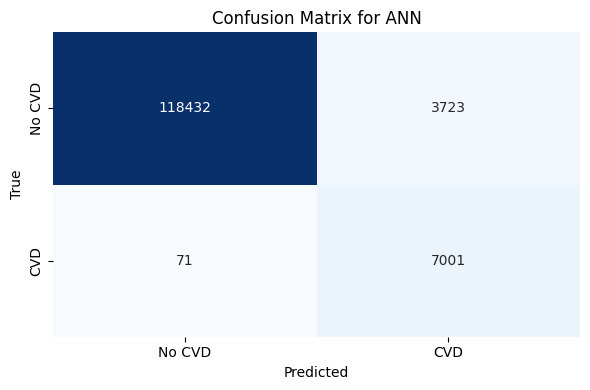

In [7]:

class_weight = {0: 1, 1: 17.57}
ann = NeuralNetwork(input_size=X_train_nn.shape[1], class_weight=class_weight)
ann.fit(X_train_nn, y_train, X_val_nn, y_val, epochs=50, lr=0.001)

# Đánh giá trên test set
y_proba = ann.forward(X_test_nn).flatten()
y_pred = (y_proba >= ann.best_thresh).astype(int)
evaluate_model(y_test, y_pred, "ANN")

In [8]:

joblib.dump(ann, '_ann.pkl')

['_ann.pkl']